In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [8]:

def read_mnist(images_path, labels_path):
    import struct
    import os
    with open(labels_path, 'rb') as p:
        magic, n = struct.unpack('>II', p.read(8))
        labels = np.fromfile(p, dtype=np.uint8)
    with open(images_path, 'rb') as p:
        magic, num, rows, cols = struct.unpack(">IIII", p.read(16))
        images = np.fromfile(p, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


def shuffle_data(features, labels, random_seed=42):
    assert len(features) == len(labels)

    if random_seed:
        np.random.seed(random_seed)
    idx = np.random.permutation(len(features))
    return [a[idx] for a in [features, labels]] 

def load_data():     
    X, y = read_mnist('data/train-images.idx3-ubyte', 'data/train-labels.idx1-ubyte')
    X, y = shuffle_data(X, y, random_seed=42)
    train_set_x, train_set_y = X[:5000], y[:5000]
    test_set_x, test_set_y = X[5000:], y[5000:]
    
    test_set_x = test_set_x.reshape(test_set_x.shape[0], -1).T
    train_set_x = train_set_x.reshape(train_set_x.shape[0], -1).T
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x, test_set_x, train_set_y, test_set_y

In [9]:
train_set_x, test_set_x, train_set_y, test_set_y = load_data()
print('train set shapes: ', train_set_x.shape, train_set_y.shape)
print('test set shapes: ', test_set_x.shape, test_set_y.shape)

train set shapes:  (784, 5000) (1, 5000)
test set shapes:  (784, 55000) (1, 55000)


In [10]:
def plot_digit(x_set, y_set, idx):
    img = x_set.T[idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % y_set.T[idx])
    plt.show()

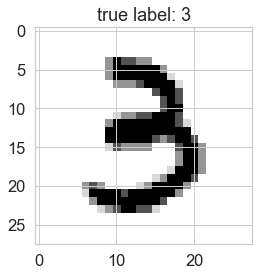

In [11]:
plot_digit(train_set_x, train_set_y, idx=1)

In [12]:
class Sigmoid:
    def __call__(self, z):

        return 1/(1+np.exp(-z))
    
    def prime(self, z):

        return self.__call__(z) * (1 - self.__call__(z))

In [13]:
def one_hot(Y, n_classes):

    onehot = np.zeros((n_classes, Y.shape[1]))
    for i in range(0,n_classes):
        a = np.where(Y[0]==i)[0]
        for j in a:
            onehot[i][j] = 1
    return onehot

In [14]:
def compute_cost(A2, Y):

    m = Y.shape[1]

    cost = (-1/m) * np.sum(np.sum(Y*np.log(A2) + (1 - Y)*np.log(1 - A2)))
    
    return cost

In [15]:
class Regularization:

    def __init__(self, lambda_1, lambda_2):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        
    def l1(self, W1, W2, m):
        
        l1_term = (self.lambda_1/m)*(np.linalg.norm(W1, ord = 1) + np.linalg.norm(W2, ord = 1))
        return l1_term

    def l1_grad(self, W1, W2, m):
        
        for i in range(len(W1)):
            if W1[i]>0: W1[i]=1
            else: W1[i]=-1
            if W2[i]>0: W2[i]=1
            else: W2[i]=-1
  
        
        l1_grads = {
            "dW1":(((self.lambda_1)*W1)/m),
            "dW2":(((self.lambda_1)*W2)/m)
        }

        return l1_grads


    def l2(self, W1, W2, m):

        l2_term = (self.lambda_2/(m*2))*(np.square(np.linalg.norm(W1, ord=2)) + np.square(np.linalg.norm(W2, ord=2)))
        return l2_term

        
    def l2_grad(self, W1, W2, m):

        l2_grads = {
            "dW1":(self.lambda_2*W1/m),
            "dW2":(self.lambda_2*W2/m)
        }

        return l2_grads

In [16]:
class NeuralNetwork:
    
    def __init__(self, n_features, n_hidden_units, n_classes , learning_rate, reg=Regularization(0.1, 0.2), sigm=Sigmoid()):
        self.n_features = n_features
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.n_hidden_units = n_hidden_units
        self.reg = reg
        self.sigm = sigm
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        
        self.initialize_parameters()

    def initialize_parameters(self):
    
        np.random.seed(42) 
        
        self.b1 = np.zeros((self.n_hidden_units,1))
        self.b2 = np.zeros((self.n_classes,1))
        
        self.W1 = np.random.normal(0, 0.01,(self.n_hidden_units, self.n_features))
        self.W2 = np.random.normal(0, 0.01, (self.n_classes, self.n_hidden_units))


    def forward_propagation(self, X):
        
        Z1 = self.W1.dot(X) + self.b1
        A1 = Sigmoid()(Z1)
        Z2 = self.W2.dot(A1) + self.b2
        A2 = Sigmoid()(Z2)

        return {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
    
    def backward_propagation(self, X, Y, cache):
        
        m = X.shape[1]
        
        Z1 = cache ["Z1"]
        A1 = cache ["A1"]
        Z2 = cache ["Z2"]
        A2 = cache ["A2"]

        m = X.shape[1]
       
        lambda1 = self.reg.l1(self.W1, self.W2, m)
        lambda2 = self.reg.l2(self.W1, self.W2, m)
        dZ2 = A2 - Y
        dW2 = (1/m) * dZ2.dot(A1.T) + (lambda1/m)*np.sign(self.W2) + (lambda2/m)*self.W2
        db2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True)
        dZ1 = self.W2.T.dot(dZ2)*Sigmoid().prime(Z1)
        dW1 = (1/m) * dZ1.dot(X.T) + (lambda1/m)*np.sign(self.W1) + (lambda2/m)*self.W1
        db1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)

        return {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }

    def update_parameters(self, grads):
        
        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        
        self.W1 = self.W1 - self.learning_rate*dW1
        self.b1 = self.b1 - self.learning_rate*db1
        self.W2 = self.W2 - self.learning_rate*dW2
        self.b2 = self.b2 - self.learning_rate*db2



In [17]:
class NNClassifier:

    def __init__(self, model, epochs=1000):
        self.model = model
        self.epochs = epochs
        self._cost = []
    
    def fit(self, X, Y):
 
        self.onehot = one_hot(Y, 10)
        self.model.initialize_parameters()
        for i in range(self.epochs):
            cache = self.model.forward_propagation(X)
            A2 = cache["A2"]
            self.grads = self.model.backward_propagation(X, self.onehot, cache)
            cost = compute_cost(A2, Y)
            self._cost.append(cost)
            self.model.update_parameters(self.grads)
    
    def predict(self, X):
        
        cache = self.model.forward_propagation(X)

        return np.argmax(cache['A2'], axis=0).T

In [18]:
def accuracy(pred, labels):
    return (np.sum(pred == labels, axis=1) / float(labels.shape[1]))[0]
print()

In [19]:
NN = NeuralNetwork(784, 30, 10, 0.01)
classifier = NNClassifier(NN, 5000)

In [20]:
classifier.fit(train_set_x, train_set_y)

In [21]:
pred_train = classifier.predict(train_set_x)
pred_test = classifier.predict(test_set_x)

print('train set accuracy: ', accuracy(pred_train, train_set_y))
print('test set accuracy: ', accuracy(pred_test, test_set_y))

train set accuracy:  0.9524
test set accuracy:  0.8615636363636363


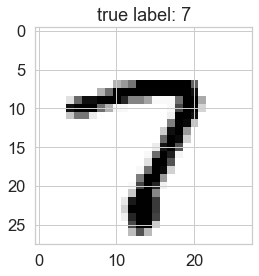

In [26]:
plot_digit(test_set_x, test_set_y, idx=100)

In [27]:
pred_single = classifier.predict(test_set_x.T[100].reshape(784, 1))
print("The digit is " + str(pred_single[0]))

The digit is 7


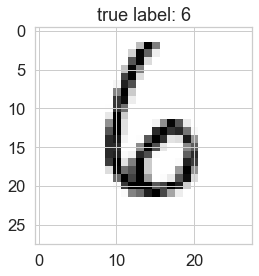

In [30]:
plot_digit(test_set_x, test_set_y, idx=200)

In [32]:
pred_single = classifier.predict(test_set_x.T[200].reshape(784, 1))
print("The digit is " + str(pred_single[0]))

The digit is 6
